In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
import pyresample
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import netCDF4
import datetime as dt
from netCDF4 import date2num,num2date

import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys


def get_var_list(list_name):
    '''
    Get a list of variables associated with a pre-defined name.
    '''
    if list_name == 'ocn':
        var_list = ['sst','sss','uocn','vocn','frzmlt']
    elif list_name == 'atmo':
        var_list = ['Tair','uatm','vatm','fswdn','flwdn','snow']
    elif list_name == 'wave':
        var_list = ['aice','wave_sig_ht','peak_period','mean_wave_dir']
    elif list_name == 'ice':
        var_list = ['aice','hi','fsdrad','iage','uvel','vvel','frazil','congel']
    elif list_name == 'JRA55':
            var_list = ['airtmp']
    elif list_name == 'static':
        var_list = ['aice','hi','hs','fsdrad','sice','iage','vlvl','vrdg']
    else:
        var_list = [list_name]

    return var_list

In [4]:
# Read in the CICE data
var_name = 'static'
variable_list = get_var_list(var_name)
num_variables = np.size(variable_list)



# '/Users/noahday/Gadi/ia40/waves-10/history/iceh.2002-08-26.nc' 
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
savepath = '/scratch/ia40/nd0349/'

os.chdir(mypath)
for year in range(2009,2010):
#    year = '2005'

    filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    onlyfiles.sort()

    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values
    # Get the total number of grid points
    size = 1
    for dim in np.shape(LN): size *= dim
    aice_data = ds['aice'][0,:,:]
    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask

    X_out =  np.ma.masked_array(np.empty((size,1)), mask=mask)

    file_dates = []
    for filecount, file in enumerate(onlyfiles):
        filename = file
        print(file)
        file_dates.append(np.datetime64(file[-13:-3]))

        ds = xr.open_dataset(filename)
        LN = ds.TLON.values
        LT = ds.TLAT.values

        aice_data = ds['aice'][0,:,:]

        mask1 = np.ma.masked_where(LT > 0.0, aice_data)
        mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
        master_mask = mask1.mask | mask2.mask
        mask = master_mask

        for counter, exp in enumerate(variable_list):
            data = ds[exp][0,:,:]
            data_masked = np.ma.masked_where(mask, data.values)
            data_masked_vec = data_masked.compressed()
            size, = data_masked_vec.shape

            if counter == 0: 
                X_temp = data_masked_vec.reshape(size,1)
            else:
                X_temp = np.concatenate([X_temp, data_masked_vec.reshape(size,1)],axis=1)

        LN_masked = np.ma.masked_where(mask, LN)
        LN_vec = LN_masked.compressed()
        LT_masked = np.ma.masked_where(mask, LT)
        LT_vec = LT_masked.compressed()
        X_temp = np.concatenate([X_temp, LN_vec.reshape(size,1), LT_vec.reshape(size,1)],axis=1)
        if filecount == 0: 
            X_out = X_temp
            datetime_vec =  np.tile(np.datetime64(file[-13:-3]),(size,1))
        else:
            X_out = np.concatenate([X_out, X_temp],axis=0)
            datetime_vec = np.concatenate([datetime_vec, np.tile(np.datetime64(file[-13:-3]),(size,1))],axis=0)


df_raw = pd.DataFrame(X_out, columns = variable_list+['longitude','latitude'])#,'date'])
df_raw['date'] = datetime_vec
df_raw = df_raw.dropna()


# Print the dataset

df_raw.describe()


/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-01.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-02.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-03.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-04.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-05.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-06.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-07.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-08.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-09.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-10.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-11.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-12.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-13.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-14.nc
/g/data/ia40/cice-dirs/runs/waves-10/history/iceh.2009-01-15.nc
/g/data/ia40/cice-dirs/runs/waves-10/his

,aice,hi,hs,fsdrad,sice,iage,vlvl,vrdg,longitude,latitude
count,2.187619e+06,2.187619e+06,2.187619e+06,2.187619e+06,2.187619e+06,2.187619e+06,2.187619e+06,2.187619e+06,2.187619e+06,2.187619e+06
mean,9.464385e-01,1.050182e+00,1.662365e-01,5.362139e+02,7.448553e+00,3.800359e-01,4.645388e-01,5.856431e-01,2.080053e+02,-6.850726e+01
std,1.347012e-01,6.192107e-01,1.386118e-01,2.991485e+02,3.646148e+00,3.039808e-01,2.476420e-01,5.577499e-01,1.001030e+02,5.036955e+00
min,1.500043e-01,6.126497e-03,0.000000e+00,5.600842e-01,2.490921e+00,1.736214e-04,4.322765e-04,1.177319e-10,5.000000e-01,-7.762990e+01
25%,9.692652e-01,5.443777e-01,5.452960e-02,2.816755e+02,5.019739e+00,1.528338e-01,2.719337e-01,1.593145e-01,1.585000e+02,-7.243740e+01
50%,9.975411e-01,1.003296e+00,1.326622e-01,6.401801e+02,6.295465e+00,3.016486e-01,4.445750e-01,4.392898e-01,2.105000e+02,-6.870660e+01
75%,9.996011e-01,1.490065e+00,2.485304e-01,8.116455e+02,8.609486e+00,5.150829e-01,6.393305e-01,8.541395e-01,3.055000e+02,-6.503162e+01
max,1.000000e+00,6.118557e+00,1.225117e+00,8.504769e+02,3.063370e+01,2.798636e+00,1.301018e+00,6.112303e+00,3.595000e+02,-5.220493e+01


,aice,hi,hs,fsdrad,sice,iage,vlvl,vrdg,longitude,latitude,date
8922,0.177647,0.242394,0.008259,2.688405,4.266751,0.689887,0.035948,0.206447,271.5,-69.173546,2005-01-01
7900,0.700098,0.908975,0.062650,711.411560,4.241323,0.678125,0.430945,0.478030,215.5,-70.492485,2005-01-01
23012,0.396644,1.190470,0.011292,3.677801,4.600779,0.562872,0.027813,1.162657,279.5,-72.437401,2005-01-02
25047,0.876580,1.625636,0.050064,820.899231,3.740461,0.972277,0.667681,0.957955,317.5,-70.066193,2005-01-02
37414,0.386072,0.605769,0.026715,519.601074,3.472609,0.701576,0.271523,0.334246,319.5,-74.415512,2005-01-03
...,...,...,...,...,...,...,...,...,...,...,...
6748003,0.857102,1.521788,0.035702,440.809662,4.177728,0.685526,0.417619,1.104169,219.5,-68.706604,2005-12-29
6762858,0.228372,0.455763,0.020392,2.710336,5.800342,0.527810,0.021826,0.433937,246.5,-71.306648,2005-12-30
6761633,0.910495,1.149991,0.029360,718.138550,4.785906,0.607243,0.730302,0.419689,327.5,-72.791801,2005-12-30
6781798,0.865883,1.000313,0.011307,653.534241,4.554741,0.617444,0.639946,0.360367,330.5,-67.730186,2005-12-31


In [ ]:
# Get row index and dates

#mask1= (df_raw['date'] == file_dates[0])
#mask2 = (df_raw['date'] == file_dates[2])

#print(mask1[1:100])
#print(mask2[-100:-1])
#

#X_train = df_raw['aice'].values
#len = X_train.shape
#len

Text(0.5, 1.0, 'Log-Min/Max')

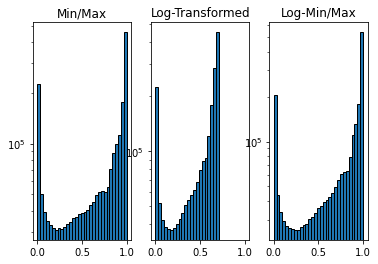

In [5]:
# Standardisation
X_train = df_raw['fsdrad'].values
len, = X_train.shape


min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train.reshape(len,1))


#create log-transformed data
X_log = np.log(X_train_minmax+1)
scaler = StandardScaler()
#scaled_features = scaler.fit_transform(X_standardized)

X_log_minmax = min_max_scaler.fit_transform(X_log.reshape(len,1))


#define grid of plots

fig, axs = plt.subplots(nrows=1, ncols=3)

#create histograms

axs[0].hist(X_train_minmax, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[1].hist(X_log, edgecolor='black',bins=31,log=True,range=[0, 1])
axs[2].hist(X_log_minmax, edgecolor='black',bins=31,log=True,range=[0, 1])


#add title to each histogram
axs[0].set_title('Min/Max')
axs[1].set_title('Log-Transformed')
axs[2].set_title('Log-Min/Max')
    


In [6]:
# Standardise all the variables

X_temp = df_raw['aice'].values
len, = X_temp.shape
row_index = len
X_train = np.zeros((row_index,1))
for counter, exp in enumerate(variable_list):
    X_temp_vec = df_raw[exp].values

    min_max_scaler = preprocessing.MinMaxScaler()
    X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))

    #create log-transformed data
#    X_temp_vec = np.log(X_temp_vec+1)
   # scaler = StandardScaler()
    X_temp_vec = min_max_scaler.fit_transform(X_temp_vec.reshape(row_index,1))
    X_train = np.concatenate([X_train, X_temp_vec],axis=1)

temp_lon = df_raw['longitude'].to_numpy()
temp_lat = df_raw['latitude'].to_numpy()
X_train = np.concatenate([X_train, temp_lon.reshape(row_index,1), temp_lat.reshape(row_index,1)],axis=1)
X_train=np.delete(X_train,0,1)

df_standard = pd.DataFrame(X_train, columns = variable_list+['longitude','latitude'])
#df_standard['date'] = df_raw['date']#np.datetime64(file_date)
df_standard['date'] = df_raw['date'].values


print(df_standard.describe())
df_standard

print(df_standard['date'])



               aice            hi            hs        fsdrad          sice  \
count  2.187619e+06  2.187619e+06  2.187619e+06  2.187619e+06  2.187619e+06   
mean   9.369860e-01  1.708086e-01  1.356904e-01  6.302428e-01  1.761600e-01   
std    1.592849e-01  1.013650e-01  1.132047e-01  3.521810e-01  1.297079e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    9.638411e-01  8.805844e-02  4.450972e-02  3.307564e-01  8.985673e-02   
50%    9.971071e-01  1.631379e-01  1.082854e-01  7.525677e-01  1.351872e-01   
75%    9.995308e-01  2.427739e-01  2.028627e-01  9.543115e-01  2.174115e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

               iage          vlvl          vrdg     longitude      latitude  
count  2.187619e+06  2.187619e+06  2.187619e+06  2.187619e+06  2.187619e+06  
mean   1.357397e-01  3.568441e-01  9.581387e-02  2.080054e+02 -6.850727e+01  
std    1.087703e-01  1.905066e-01  9.131096e-02  1.002

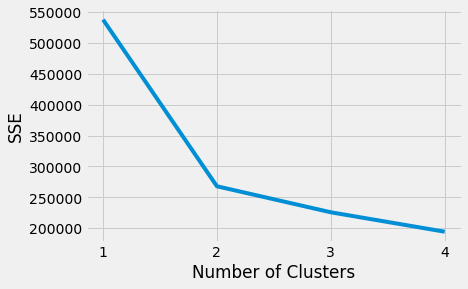

<Figure size 432x288 with 0 Axes>

In [7]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)
#print(df_standard.iloc[:, 3] )
del X_train
X_train = df_standard.iloc[:, 0:-3] 
X_train
kmeans.fit(X_train)

# The lowest SSE value
kmeans.inertia_

# Final locations of the centroid
kmeans.cluster_centers_

# The number of iterations required to converge
kmeans.n_iter_
kmeans.labels_[:5]


kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 5), sse)
plt.xticks(range(1, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
plt.savefig(savepath+'SSE.png', dpi = 300)  



In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    score = silhouette_score(X_train, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 5), silhouette_coefficients)
plt.xticks(range(2, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()
plt.savefig(savepath+'silhouette.png', dpi = 300)  

In [8]:
# Initial centroid
#0.0123    0.0054    0.0009    0.0077    0.0139    0.0075    0.0013    0.0048
#0.9825    0.4804    0.2950    0.9470    0.5100    0.2033    0.3641    0.3532
#0.9432    0.1913    0.0802    0.7402    0.6518    0.0914    0.2116    0.0867

init_centroids = np.array([[0.223, 0.0054, 0.0009, 0.0007, 0.0139, 0.0075, 0.0013, 0.0048], [0.9825, 0.4804, 0.2950, 0.9470, 0.5100, 0.2033, 0.3641, 0.3532], [0.9432, 0.1913, 0.0802, 0.7402, 0.6518, 0.0914, 0.2116, 0.0867]])

init_centroids2 = np.array([[0.96221878, 0.08398237, 0.06508808, 0.04646253, 0.3788989,  0.05517018, 0.21942225], [0.95768088, 0.29923383, 0.24225471, 0.21369082, 0.13641108, 0.1632028,  0.31585801], [0.95627117, 0.2773644,  0.18689209, 0.84940695, 0.17923583, 0.17167591, 0.46987752]])
# [0.33422491, 0.11073472, 0.04112143, 0.17990378, 0.19245547, 0.22089278,  0.06789923]
kmeans = KMeans(
#    init="random",
    init=init_centroids2,
    n_clusters=3,
#    n_init=10, #10,
    max_iter=300,
    random_state=2020
)

# Take a sub-sample (same number of points for each date)
#df_temp = df_standard
df_temp = df_standard.drop(df_raw[df_raw.aice < 0.15].index)
df_subsample = df_temp.groupby('date', group_keys=False).apply(lambda x: x.sample(500))
#df_subsample = df_temp
X_train = df_subsample.iloc[:, 0:7] 
#X_train = df_standard.iloc[:, 0:4] 

kmeans.fit(X_train)
#kmeans.cluster_centers_ = init_centroids

X_all = df_standard.iloc[:, 0:7] 
predicted = kmeans.predict(X_all) 

df_kmeans = df_standard
df_kmeans['k'] = predicted # kmeans.labels_

print(kmeans.cluster_centers_)
#df_kmeans.to_csv('kmeans.csv', index=False)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1307: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


[[0.74075234 0.06711177 0.03998849 0.06061613 0.2863485  0.11256055
  0.12865605]
 [0.9685029  0.12908845 0.11572354 0.44246914 0.17396045 0.10704401
  0.29112328]
 [0.93930583 0.22097461 0.15447818 0.90514096 0.13483395 0.18972245
  0.39594764]]


In [ ]:

unique_dates = df_kmeans['date'].unique()
tmp1, = unique_dates.shape
tmp2, tmp3 = LN.shape
k_means_array = np.empty((tmp1,tmp2,tmp3))
k_means_array[:] = np.nan


#time[:] = unique_dates[1:10]
#print(unique_dates[:])
#dates = [dt.datetime(2005,10,1,0),dt.datetime(2014,10,2,0),dt.datetime(2014,10,3,0),dt.datetime(2014,10,4,0)]

for time_lp, date_tmp in enumerate(unique_dates):
    date_idx = df_kmeans['date'] == date_tmp

    lon = df_kmeans['longitude'][date_idx];
    lat = df_kmeans['latitude'][date_idx];
    k = df_kmeans['k'][date_idx];

    row_length = date_idx.sum()
    lon = lon.values.reshape(row_length,1)
    lat = lat.values.reshape(row_length,1)
    k = k.values.reshape(row_length,1)
    print(date_tmp)
    print(date_idx.sum())
    for row_lp in range(0, row_length):
        a = abs(LT-lat[row_lp])+abs(LN-lon[row_lp])
        i,j = np.unravel_index(a.argmin(),a.shape)
        k_means_array[time_lp,i,j] = k[row_lp]

    
    


In [ ]:
#k_means_array[1,:,:].namean()
#np.nanmean(k_means_array[8,:,:])
#var_list_save = ['aice','fsdrad','wave_sig_ht','
unique_dates = df_kmeans['date'].unique()
tmp1, = unique_dates.shape
tmp2, tmp3 = LN.shape
aice_array = np.empty((tmp1,tmp2,tmp3))
fsdrad_array = np.empty((tmp1,tmp2,tmp3))
swh_array = np.empty((tmp1,tmp2,tmp3))
#aice_array[:] = np.nan

for filecount, file in enumerate(onlyfiles):
    filename = file
    print(file)

    ds = xr.open_dataset(filename)
    LN = ds.TLON.values
    LT = ds.TLAT.values

    aice_data = ds['aice'][0,:,:]

    mask1 = np.ma.masked_where(LT > 0.0, aice_data)
    mask2 = np.ma.masked_where(aice_data < 0.15, aice_data)
    master_mask = mask1.mask | mask2.mask
    mask = master_mask
#    for counter, exp in enumerate(variable_list):

    data = ds['aice'][0,:,:]
    aice_array[filecount,:,:] = data
    aice_array[filecount,mask] = np.nan
    
    data = ds['fsdrad'][0,:,:]
    fsdrad_array[filecount,:,:] = data
    fsdrad_array[filecount,mask] = np.nan
    
    data = ds['wave_sig_ht'][0,:,:]
    swh_array[filecount,:,:] = data
    swh_array[filecount,mask] = np.nan
    
aice_array

In [40]:
onlyfiles[0]
unique_dates = df_kmeans['date'].unique()
tmp1, = unique_dates.shape
tmp2, tmp3 = LN.shape
aice_array = np.empty((tmp1,tmp2,tmp3))
#aice_array[:] = np.nan

#aice_array.shape()
#aice_array.shape
aice_array[filecount,:,:] = aice_data
aice_array[filecount,mask] = np.nan
aice_array[filecount,:,:]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [47]:
#filename=f"/home/566/nd0349/kmeans_{year:s}.nc"
# HTE, HTN, tarea, tmask
ds = xr.open_dataset(onlyfiles[0])
HTE = ds.HTE.values
HTN = ds.HTN.values
tarea = ds.tarea.values
tmask = ds.tmask.values

filename=f"/home/566/nd0349/kmean_2009.nc"
d_vars = {"k" : (['time','nj','ni'],k_means_array,
                              {'long_name' :"k-means_clusters",
                               'units'     :"cluster number",
                               '_FillValue':-2e8}),
          "aice" : (['time','nj','ni'],aice_array,
                              {'long_name' :"sea ice area",
                               'units'     :"-",
                               '_FillValue':-2e8}),
          "fsdrad" : (['time','nj','ni'],fsdrad_array,
                              {'long_name' :"Representative floe radius",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "wave_sig_ht" : (['time','nj','ni'],swh_array,
                              {'long_name' :"Signficant wave height",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "HTE" : (['nj','ni'],HTE,
                          {'long_name':"T cell width on East side",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "HTN" : (['nj','ni'],HTN,
                          {'long_name':"T cell width on North side",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "tarea" : (['nj','ni'],tarea,
                          {'long_name':"area of T grid cells",
                           'units'    :"m^2",
                           '_FillValue':-2e8}),
          "tmask" : (['nj','ni'],tmask,
                          {'long_name':"ocean grid mask",
                           'units'    :"Boolean",
                           '_FillValue':-2e8})}
          
coords = {"LON"  : (["nj","ni"],LN,{'units':'degrees_east'}),
          "LAT"  : (["nj","ni"],LT,{'units':'degrees_north'}),
          "time" : (["time"],unique_dates)}
attrs = {'creation_date': "2023-04-03",#datetime.now().strftime('%Y-%m-%d %H'),
         'conventions'  : "",
         'title'        : "k-means clusters for CICE-WIM standalone 1-degree data",
         'source'       : ", ",
         'comment'      : "",
         'author'       : 'Noah Day',
         'email'        : 'noah.day@adelaide.edu.au'}
enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
write_job = nc_out.to_netcdf(filename,unlimited_dims=['time'],compute=False)#,encoding={'glbrad':enc_dict})

In [ ]:
# Create a netcdf data cube of just k-means
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfile = netCDF4.Dataset('/g/data/ia40/kmeans_2023-03-30.nc',mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)

length,width = LN.shape
nx = ncfile.createDimension('nx',width)
ny = ncfile.createDimension('ny',length)
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

# Define two variables with the same names as dimensions,
# a conventional way to define "coordinate variables".
lats = ncfile.createVariable('TLAT','f4',('ny','nx'),fill_value=0)
lons = ncfile.createVariable('TLON','f4',('ny','nx'),fill_value=0)
lats.long_name = 'latitude'
lats.units = 'degrees_north'
lons.long_name = 'longitude'
lons.units = 'degrees_east'

time = ncfile.createVariable('time', 'f4', ('time',))
time.units = 'days starting from 2005-01-01'
time.long_name = 'time'

kmeans_netcdf = ncfile.createVariable('k', 'f4',('time','ny','nx')) # note: unlimited dimension is leftmost
kmeans_netcdf.units = 'Cluster number'
kmeans_netcdf.standard_name = 'k-means_clusters'

# Write the data in
lats[:,:] = LT
lons[:,:] = LN
kmeans_netcdf[:,:,:] = k_means_array
print("-- Wrote data, temp.shape is now ", kmeans_netcdf.shape)
# read data back from variable (by slicing it), print min and max
print("-- Min/Max values:", kmeans_netcdf[:,:,:].min(), kmeans_netcdf[:,:,:].max())


time[:] = range(1,tmp1) #unique_dates


# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')



In [ ]:
k_means_array.shape
print(LT.shape)
#lats.shape
LN
unique_dates.data

In [ ]:
# -----------------------
nyears = 16;
unout = 'days since 2000-01-01 00:00:00'
# -----------------------
ny, nx = (250, 186)
lon = np.linspace(9,30,nx);
lat = np.linspace(50,60,ny);

dataout = np.random.random((nyears,ny,nx)); # create some random data
datesout = [dt.datetime(2000+iyear,1,1) for iyear in range(nyears)]; # create datevalues
# =========================
ncout = Dataset('myfile.nc','w','NETCDF3'); # using netCDF3 for output format 
ncout.createDimension('lon',nx);
ncout.createDimension('lat',ny);
ncout.createDimension('time',nyears);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = lon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = lat;
timevar = ncout.createVariable('time','float64',('time'));timevar.setncattr('units',unout);timevar[:]=date2num(datesout,unout);
myvar = ncout.createVariable('myvar','float32',('time','lat','lon'));myvar.setncattr('units','mm');myvar[:] = dataout;
ncout.close();

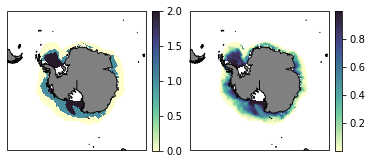

In [10]:
filename
ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values

selected_date = '2005-05-01'
date_idx = df_kmeans['date'] == selected_date

lon = df_kmeans['longitude'][date_idx];
lat = df_kmeans['latitude'][date_idx];
k = df_kmeans['k'][date_idx];
ra = df_kmeans['fsdrad'][date_idx];

row_length = date_idx.sum()
lon = lon.values.reshape(row_length,1)
lat = lat.values.reshape(row_length,1)
k = k.values.reshape(row_length,1)
ra = ra.values.reshape(row_length,1)

k_means_array = np.empty(LN.shape)
k_means_array[:] = np.nan

fsdrad_array = np.empty(LN.shape)
fsdrad_array[:] = np.nan

lats = LT
lons = LN

for row_lp in range(0, row_length):
    a = abs(lats-lat[row_lp])+abs(lons-lon[row_lp])
    i,j = np.unravel_index(a.argmin(),a.shape)
    k_means_array[i,j] = k[row_lp]
    fsdrad_array[i,j] = ra[row_lp]

fontprops = fm.FontProperties(size=18)
plt.figure()
cmap = cmo.deep
coord_lims = [-180, 180, -50, -90]

ax = plt.subplot(1, 2, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, k_means_array,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
#gl = ax.gridlines(draw_labels=False)
#scalebar = AnchoredSizeBar(ax.transData,
#                           100000, '100 km', 'lower center', 
#                           pad=0.1,
#                           color='black',
#                           frameon=False,
#                           size_vertical=1,
#                           fontproperties=fontprops)
#
#ax.add_artist(scalebar)
#plt.savefig('kmean.png', dpi = 300)  

ax = plt.subplot(1, 2, 0+2, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, fsdrad_array,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
#scalebar = AnchoredSizeBar(ax.transData,
#                           100000, '100 km', 'lower center', 
#                           pad=0.1,
#                           color='black',
#                           frameon=False,
#                           size_vertical=1,
#                           fontproperties=fontprops)
#ax.add_artist(scalebar)
plt.savefig(savepath+'kmean_and_fsdrad_'+selected_date+'.png', dpi = 300)  



[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
# Calculate MIZ width
ds = xr.open_dataset("/home/566/nd0349/kmean_2009.nc")
n_days, n_lat, n_lon = ds['k'].shape
print(ds['k'].shape)
print(ds['HTE'].shape)
print(n_lon)
print(ds['HTE'][:,n_lon-1].shape)
miz_cluster = 0 # What cluster does the MIZ correspond with?

# Initialise storage
#miz_width_array[,n_lon] = np.empty
miz_width_array = np.empty((n_days,n_lon))
effective_miz_width_array = np.empty((n_days,n_lon))

print(miz_width_array.shape)
# Circumpolar for each day
for day_idx in range(0,n_days):
    for lon_idx in range(0,n_lon):
        # MIZ width
#        print(lon_idx)
#        print(ds['k'][day_idx,:,lon_idx].data)
        miz_idx = ds['k'][day_idx,:,lon_idx].data == miz_cluster
        if not any(miz_idx):
            # If there are no MIZ cells then set distance to 0
            miz_width_array[day_idx,lon_idx] = 0
        else:
            miz_width_array[day_idx,lon_idx] = ds['HTE'][miz_idx,lon_idx].data.sum()
#            print(ds['HTE'][miz_idx,lon_idx].data)#*ds['aice'][miz_idx,lon_idx].data)
#            print(ds['aice'][day_idx,miz_idx,lon_idx].data)
#            print(np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][day_idx,miz_idx,lon_idx].data).shape)
            effective_miz_width_array[day_idx,lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][day_idx,miz_idx,lon_idx].data).sum()
                  
                  
#        print(miz_idx.shape)
#        print(miz_idx)
#        print(ds['HTE'][miz_idx,lon_idx].data)
#        print(ds['HTE'][miz_idx,lon_idx].data.sum())
        
#        print(miz_width_array[day_idx,lon_idx])

print(miz_width_array.mean(axis=1))
#effective_miz_width_array.shape
print(effective_miz_width_array.mean(axis=1))



(365, 300, 360)
(300, 360)
360
(300,)
(365, 360)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


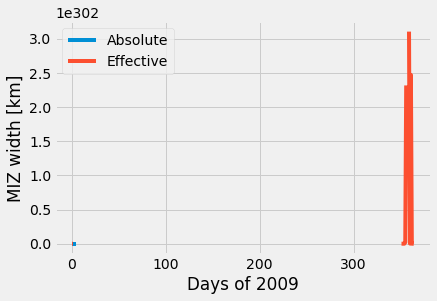

<Figure size 432x288 with 0 Axes>

In [153]:
#not any(miz_idx)

# Plot the MIZ widths
plt.style.use("fivethirtyeight")
plt.plot(range(0, n_days), miz_width_array.mean(axis=1)/1000, label = "Absolute")
plt.plot(range(0, n_days), effective_miz_width_array.mean(axis=1)/1000, label = "Effective")
#plt.xticks(range(0, n_days))
plt.xlabel("Days of 2009")
plt.ylabel("MIZ width [km]")
plt.legend()
plt.show()
plt.savefig(savepath+'miz_width.png', dpi = 300) 


TypeError: Dimensions of C (8770, 1) are incompatible with X (8770) and/or Y (8771); see help(pcolormesh)

/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/noahday/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value

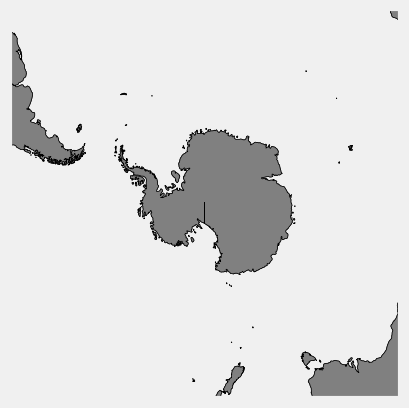

In [53]:
#print(k.shape)

plt.figure()
cmap = cmo.deep
coord_lims = [-180, 180, 90, -90]
ax.set_extent(coord_lims, ccrs.PlateCarree())
ax = plt.subplot(1, 1, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(lon, lat, k,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
plt.savefig(savepath+'kmean.png', dpi = 300)  

#k
#filename










len_tmp, = kmeans.labels_.shape
kmean_datavec = kmeans.labels_.reshape((len_tmp,1))

coord_lims = [-180, 180, -40, -90]
ax = plt.subplot(1, 1, 0+1, projection=ccrs.SouthPolarStereo(), label='{0}'.format(counter))
#print('     ' + exp)
#ax= plot_map(ax,exp,ds,LN,LT)
#ax = plt(projection=ccrs.SouthPolarStereo())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
ax.set_extent(coord_lims, ccrs.PlateCarree())
#gl = ax.gridlines(draw_labels=False)
sic_threshold = 0.05 
aice_data = ds['aice'][0,:,:]

plot_data = aice_data #ds[exp][0,:,:]
plot_data = np.ma.masked_where(aice_data < sic_threshold, plot_data)

cmap = cmo.deep
#cmap = cmap.reversed()

#p1 = ax.pcolormesh(LN,LT,plot_data, 
p1 = ax.pcolormesh(df_standard['longitude'],df_standard['latitude'], kmean_datavec,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
               # norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p1, orientation='vertical', fraction=0.046, pad=0.04)
#fontsize = 6
#cb.ax.set_ylabel( ds[exp].attrs["long_name"].partition(' of ')[0] + ' [' +  ds[exp].attrs["units"] + ']' , size=fontsize);
#cb.ax.tick_params(labelsize=fontsize) 


In [ ]:
kmeans.labels_.shape

kmean_datavec.shape